# physik690 - Bachelorarbeit

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter', 'notebook'])
plt.rcParams["figure.figsize"] = (12, 8)

<ErrorbarContainer object of 3 artists>

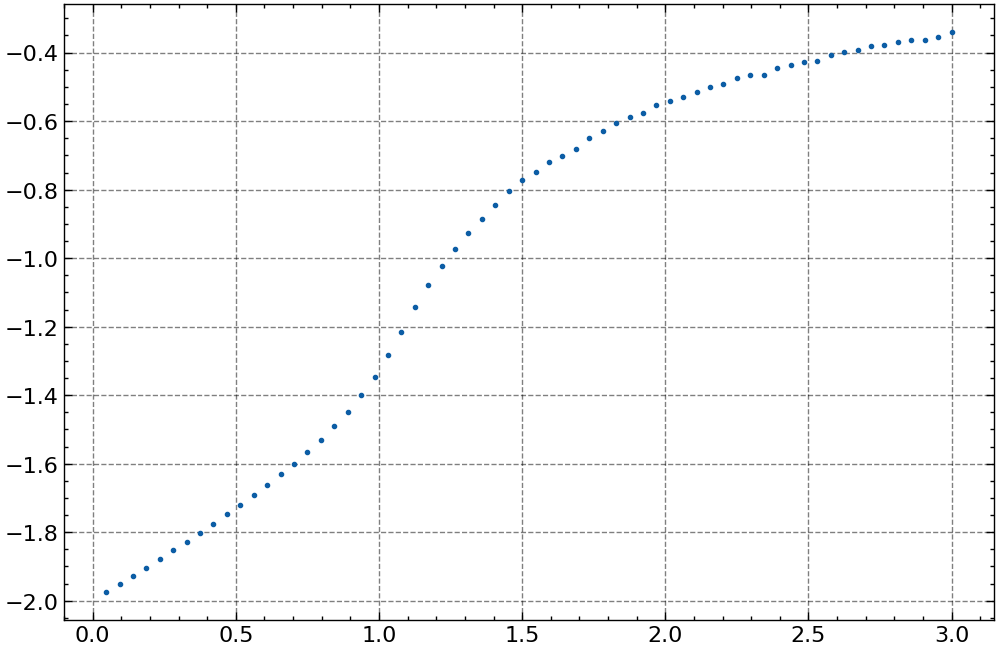

In [23]:
data = pd.read_csv('output/wolff.csv')
plt.errorbar(data['temperature'], data['e_mean'], yerr=data['e_stddev'])

<ErrorbarContainer object of 3 artists>

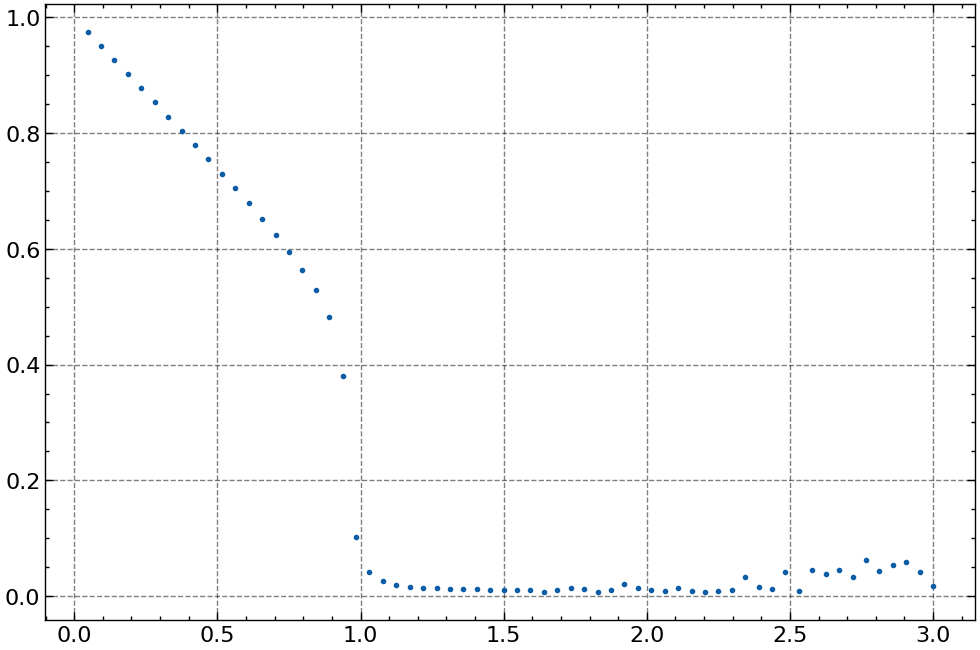

In [20]:
data = pd.read_csv('output/wolff.csv')
plt.errorbar(data['temperature'], data['m_mean'], yerr=data['m_stddev'])